In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# Realizar a exibição de uma imagem dentro de um notebook Jupyter

def show_image(window_name, image, cmap=None):
    if image is None:
        print(f"{window_name}: imagem nao carregada (None)")
        return

    if len(image.shape) == 3 and image.shape[2] == 3:
        img_disp = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        img_disp = image
        if cmap is None:
            cmap = 'gray'
    plt.figure(figsize=(8, 6))
    plt.title(window_name)
    plt.axis('off')
    plt.imshow(img_disp, cmap=cmap)
    plt.show()

def close_all_windows():
    pass

In [3]:
# Configurações de área mínima e máxima para detecção de contornos
# Os parametros foram escolhidos com bases em testes nas imagens 

MIN_AREA = 400
MAX_AREA = 1200

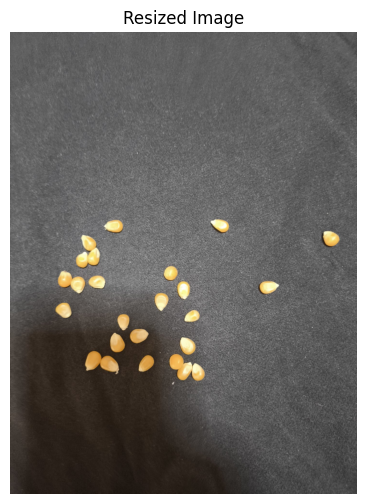

In [4]:
# Carregar a imagem

img = cv2.imread('imagens/teste1.jpg')
# img = cv2.imread('imagens/separado2.jpg')

# Redimensionar a imagem para facilitar o processamento e clonagem
img = cv2.resize(img, (960, 1280))
craped_img = img.copy()

show_image("Resized Image", img)

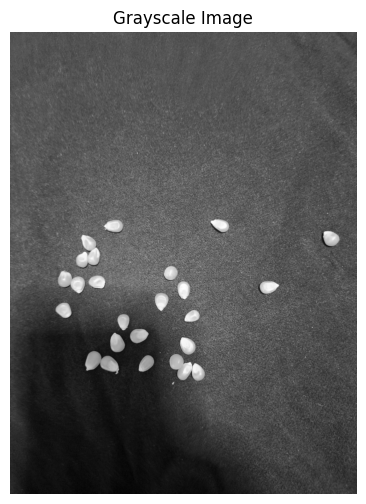

In [5]:
# Converte a imagem de BGR para tons de cinza.
# Isso reduz a complexidade da imagem para um único canal de intensidade, facilitando etapas posteriores como limiarização e detecção de bordas.

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image("Grayscale Image", gray)

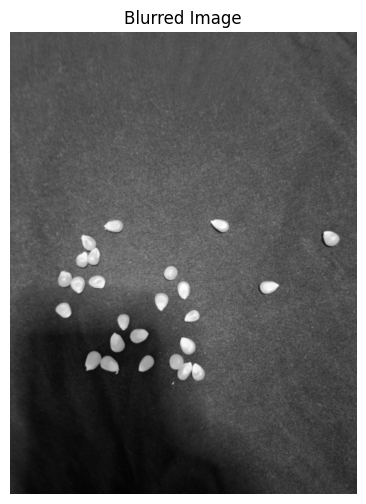

In [6]:
# Aplica um desfoque Gaussiano para suavizar a imagem e reduzir ruídos.
# O kernel 5x5 cria uma suavização leve, preparando a imagem para etapas, como threshold e detecção de bordas.

blur = cv2.GaussianBlur(gray, (5, 5), 0)
show_image("Blurred Image", blur)

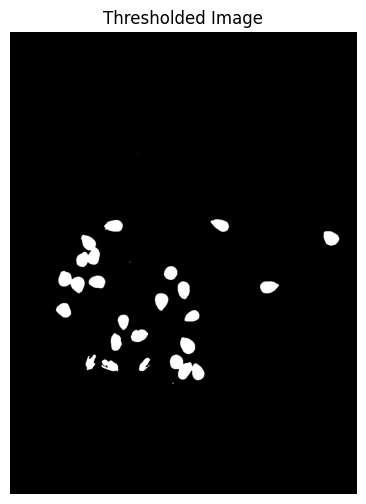

In [7]:
# Aplica uma binarização simples na imagem suavizada.
# Todo pixel com valor acima de 165 vira branco (255), e pixels abaixo viram preto (0). 
# Isso cria uma máscara binária, que facilita a identificação de objetos na imagem.

_, thresh = cv2.threshold(blur, 165, 255, cv2.THRESH_BINARY)
show_image("Thresholded Image", thresh)

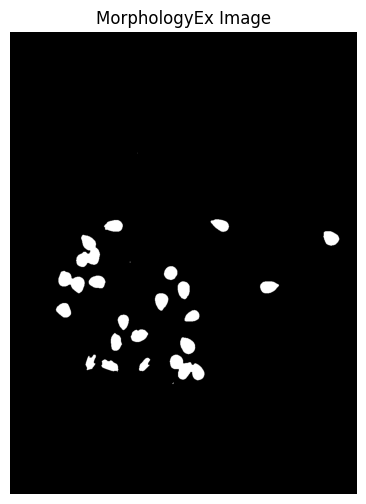

In [8]:
# Aplica a operação morfológica 'Closing' para fechar pequenos buracos e unir regiões brancas que estão próximas.
# O kernel 5x5 define o tamanho da área considerada na operação. Isso melhora a máscara binária, deixando os objetos mais completos antes da detecção de contornos.

morphologyEx = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

show_image("MorphologyEx Image", morphologyEx)

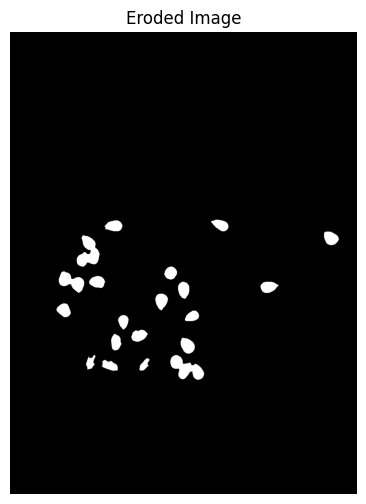

In [9]:
# Cria um kernel (elemento estruturante) retangular 3x3.
# Esse kernel define a área usada nas operações morfológicas.

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# Aplica erosão para reduzir regiões brancas e remover pequenos ruídos.
# A erosão também separa objetos que podem ter ficado conectados após o closing.
eroded = cv2.erode(morphologyEx, kernel, iterations=1)

show_image("Eroded Image", eroded)

In [10]:
# Detecta os contornos presentes na imagem binária.

contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# for i, c in enumerate(contours):
#     x, y, w, h = cv2.boundingRect(c)
#     cv2.putText(img, f"{i+1}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
#     cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
# print("Objetos detectados:", len(contours))
# show_image("Detected Objects", img)

In [11]:
# Faz uma media da area dos contornos validos para definir novos limites dinamicos

average_area = 0
new_contours = []
count_valid = 0
for i, c in enumerate(contours):
    x, y, w, h = cv2.boundingRect(c)
    area = w * h
    if area < MIN_AREA or area > MAX_AREA:
        continue
    average_area += area
    new_contours.append(c)
    count_valid += 1

average_area /= count_valid if count_valid else 1
MIN_AVERAGE_AREA = average_area * 0.75
MAX_AVERAGE_AREA = average_area * 1.75

In [12]:
# Classifica o grão com base na área do contorno e nas características de cor
def classify_grain(grain_img, contour_area):
    # Verifica se a área do contorno está dentro dos limites aceitáveis
    if contour_area < MIN_AVERAGE_AREA:
        return "small", "area too small (noise)"

    if contour_area > MAX_AVERAGE_AREA:
        return "bad_detection", "area too large (probably multiple grains)"

    # Converte a imagem do grão para o espaço de cores HSV
    hsv = cv2.cvtColor(grain_img, cv2.COLOR_BGR2HSV)
    h_mean = np.mean(hsv[:, :, 0])
    s_mean = np.mean(hsv[:, :, 1])
    v_mean = np.mean(hsv[:, :, 2])

    # Classificação baseada nos valores médios de H, S e V (espaço HSV).
    # Para milho, esses ranges funcionam bem pela característica natural das cores.

    # Grãos queimados tendem a ser escuros e com pouca saturação.
    # V < 90 → pouca luminosidade (grão escuro)
    # S < 60 → cor "morta", sem intensidade
    if v_mean < 90 and s_mean < 60:
        return "burned", f"dark grain (H={h_mean:.1f}, S={s_mean:.1f}, V={v_mean:.1f})"

    # Grãos esverdeados possuem Hue (H) entre 40 e 80 no espaço HSV do OpenCV.
    # Esse range corresponde exatamente aos tons de verde.
    if 40 <= h_mean <= 80:
        return "greenish", f"green hue (H={h_mean:.1f})"

    # Grãos bons (saudáveis) possuem tonalidade amarela.
    # Amarelo no HSV fica entre ~18 e 35.
    # V > 100 garante que o grão não está escurecido ou queimado.
    if 18 <= h_mean <= 35 and v_mean > 100:
        return "good", f"healthy yellow grain (H={h_mean:.1f})"

     # Caso não entre em nenhum padrão conhecido, marca como indefinido.
    return "unknown", f"undefined color pattern (H={h_mean:.1f})"

Parametros de área média: 
Área média: 1070.75
MIN_AVERAGE_AREA: 803.06
MAX_AVERAGE_AREA: 1873.81

Objeto 1: x=254, y=908, w=44, h=31, area=1364
Classificação: unknown (undefined color pattern (H=17.4))

Objeto 2: x=358, y=904, w=28, h=34, area=952
Classificação: unknown (undefined color pattern (H=17.9))

Objeto 3: x=443, y=895, w=94, h=69, area=6486
Classificação: bad_detection (area too large (probably multiple grains))

Objeto 4: x=210, y=895, w=26, h=40, area=1040
Classificação: unknown (undefined color pattern (H=17.9))

Objeto 5: x=472, y=847, w=39, h=44, area=1716
Classificação: good (healthy yellow grain (H=26.6))

Objeto 6: x=280, y=836, w=28, h=46, area=1288
Classificação: good (healthy yellow grain (H=18.1))

Objeto 7: x=335, y=825, w=46, h=33, area=1518
Classificação: unknown (undefined color pattern (H=17.9))

Objeto 8: x=299, y=784, w=29, h=40, area=1160
Classificação: good (healthy yellow grain (H=19.5))

Objeto 9: x=484, y=772, w=39, h=29, area=1131
Classificação: good

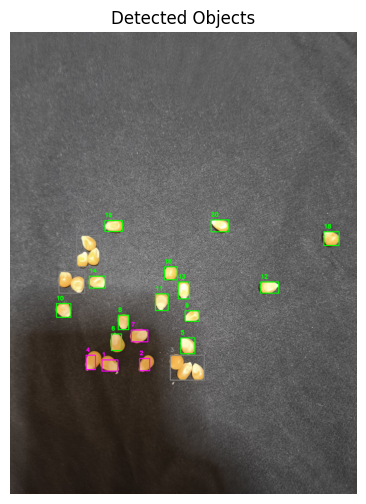

Resumo da classificação dos grãos:
good: 13
burned: 0
greenish: 0
bad_detection: 3
small: 0
unknown: 4


In [13]:
grains = {
    'good': 0,
    'burned': 0,
    'greenish': 0,
    'bad_detection': 0,
    'small': 0,
    'unknown': 0
}

colors = {
    'good': (0, 255, 0),
    'burned': (0, 0, 255),
    'greenish': (255, 255, 0),
    'bad_detection': (128, 128, 128),
    'small': (0, 255, 255),
    'unknown': (255, 0, 255)
}

print("Parametros de área média: ")
print(f"Área média: {average_area:.2f}")
print(f"MIN_AVERAGE_AREA: {MIN_AVERAGE_AREA:.2f}")
print(f"MAX_AVERAGE_AREA: {MAX_AVERAGE_AREA:.2f}\n")

# Análise e classificação dos contornos detectados
for i, c in enumerate(contours):
    x, y, w, h = cv2.boundingRect(c)
    grain = craped_img[y:y+h, x:x+w]
    
    # hsv = cv2.cvtColor(grain, cv2.COLOR_BGR2HSV)
    # h_mean = np.mean(hsv[:, :, 0])
    # s_mean = np.mean(hsv[:, :, 1])
    # v_mean = np.mean(hsv[:, :, 2])
    # print(f"Média HSV: H={h_mean:.2f}, S={s_mean:.2f}, V={v_mean:.2f}")
    
    area = w * h
    
    classification, reason = classify_grain(grain, area)
    grains[classification] += 1
    print(f"Objeto {i+1}: x={x}, y={y}, w={w}, h={h}, area={w*h}")
    print(f"Classificação: {classification} ({reason})\n")
    # show_image(f"Objeto {i+1}", grain)

    cv2.putText(img, f"{i+1}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[classification], 2)
    cv2.rectangle(img, (x, y), (x+w, y+h), colors[classification], 2)

show_image("Detected Objects", img)
print("Resumo da classificação dos grãos:")
for category, count in grains.items():
    print(f"{category}: {count}")